Exploratory data analysis dataset
=================================

## CARGO LOS DATOS

In [1]:
import pandas as pd
import numpy as np
import os

ruta = 'coronary_disease.csv'

# Cargamos el archivo
df = pd.read_csv(ruta)

# Mostramos las primeras filas para verificar que todo esté bien
df.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,M,39,4.0,No,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,F,46,2.0,No,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,M,48,1.0,Yes,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,F,61,3.0,Yes,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,F,46,3.0,Yes,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## VEO CUANTOS MISSING VALUES HAY EN CADA CATEGORÍA

In [2]:
# 1. Ver el conteo exacto de valores faltantes por columna
missing_data = df.isnull().sum()

# 2. Calcular el porcentaje de valores faltantes (opcional pero muy útil)
missing_percentage = (df.isnull().sum() / len(df)) * 100

# 3. Crear una tabla resumen
resumen_missing = pd.DataFrame({
    'Valores Nulos': missing_data,
    'Porcentaje (%)': missing_percentage
})

# Mostrar solo las variables que tienen algún nulo
print(resumen_missing[resumen_missing['Valores Nulos'] > 0])
print(" ")
print("El data set contiene", len(df), "registros")

            Valores Nulos  Porcentaje (%)
education             105        2.477584
cigsPerDay             29        0.684285
BPMeds                 53        1.250590
totChol                50        1.179802
BMI                    19        0.448325
heartRate               1        0.023596
glucose               388        9.155262
 
El data set contiene 4238 registros


In [3]:
df_sin_nulls = df.copy()

## MISSING VALUES - glucose

- En los NULL de pacientes diabéticos pongo la mediana de glucosa de los diabéticos
- En los NULL de pacientes no diabéticos pongo la mediana de glucosa de los no diabéticos

In [4]:
# Rellenamos los nulos de 'glucose' basándonos en si son diabéticos o no
df_sin_nulls['glucose'] = df_sin_nulls['glucose'].fillna(df_sin_nulls.groupby('diabetes')['glucose'].transform('median'))

# Verificamos si aún quedan nulos en glucosa
print(f"Nulos en glucosa tras la imputación: {df_sin_nulls['glucose'].isnull().sum()}")

Nulos en glucosa tras la imputación: 0


## MISSING VALUES - cigsPerDay

- No hay NULLS en pacientes fumadores --> todo es 0
- En los NULLS de pacientes fumadores pongo la mediana de cigarros por dia de los fumadores

In [5]:
# Los que no fuman deberían tener 0 cigarrillos, los que sí fuman, la mediana de fumadores
df_sin_nulls['cigsPerDay'] = df_sin_nulls['cigsPerDay'].fillna(df_sin_nulls.groupby('currentSmoker')['cigsPerDay'].transform('median'))

print(f"Nulos en cigsPerDay tras la imputación: {df_sin_nulls['cigsPerDay'].isnull().sum()}")

Nulos en cigsPerDay tras la imputación: 0


## MISSING VALUES - education

Teniendo en cuenta la cantidad de NULLS que hay y el poco valor médico que aporta esta información para el modelo, se decide borrar esta columna

In [6]:
df_sin_nulls.drop(columns=['education'], inplace=True)

## MISSING VALUES - (BMI, heartRate)

Hay muy pocos missing values por lo que se decide eliminar esos registros del dataset ya que no afectará al total de los 4000 y pico registros que hay

In [7]:
df_sin_nulls.dropna(subset=['BMI', 'heartRate'], inplace=True)


## MISSING VALUES - BPMed

Si un paciente es hipertenso es probable que tome medicación, por lo que le asignaremos el valor de la moda del grupo de hipertensos y el de los no hipertensos el de los no hipertensos 

In [8]:
# Imputamos BPMeds con la moda de su grupo de hipertensión
df_sin_nulls['BPMeds'] = df_sin_nulls['BPMeds'].fillna(df_sin_nulls.groupby('prevalentHyp')['BPMeds'].transform(lambda x: x.mode()[0]))

## MISSING VALUES - totChol

En los missing values que tenemos, se rellena con la mediana de todos los otros datos

In [9]:
# Rellenamos con la mediana de toda la columna
df_sin_nulls['totChol'] = df_sin_nulls['totChol'].fillna(df_sin_nulls['totChol'].median())

## Comprobar distribuciones

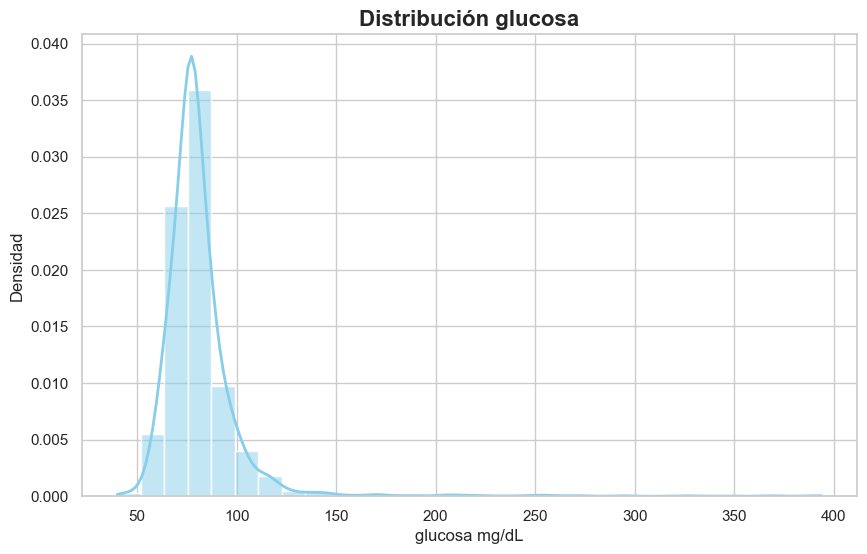

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del estilo (equivalente a theme_minimal)
sns.set_theme(style="whitegrid")

# Crear la figura
plt.figure(figsize=(10, 6))

# Histograma con curva de densidad (KDE)
sns.histplot(df_sin_nulls['glucose'], 
             bins=30, 
             kde=True, 
             stat="density", 
             color="skyblue", 
             edgecolor="white",
             line_kws={"color": "red", "linewidth": 2})

# Personalización de etiquetas (equivalente a labs)
plt.title("Distribución glucosa", fontsize=16, fontweight='bold')
plt.xlabel("glucosa mg/dL", fontsize=12)
plt.ylabel("Densidad", fontsize=12)

# Mostrar gráfico
plt.show()

In [27]:
# Función que agrupa el DataFrame en grupo_cols y calcula la media de las variables numéricas 
def group_and_average(df, group_cols):
    numeric_cols = df.select_dtypes(include='number').columns
    numeric_cols = numeric_cols.difference(group_cols)
    
    return (
        df
        .groupby(group_cols)[numeric_cols]
        .mean()
        .reset_index()
    )


In [28]:
# Promedio por sexo
df_avg_sex = group_and_average(df_sin_nulls, ['sex'])
df_avg_sex

,sex,BMI,BPMeds,TenYearCHD,age,cigsPerDay,diaBP,diabetes,glucose,heartRate,prevalentHyp,prevalentStroke,sysBP,totChol
0,F,25.512636,0.036590,0.121830,49.794595,5.829938,82.313306,0.023285,81.492308,77.101871,0.308108,0.005821,133.040956,239.462370
1,M,26.183944,0.019305,0.187534,49.277441,13.417540,83.691947,0.028130,81.797573,74.254275,0.312741,0.004964,131.375621,233.146167


In [29]:
# Promedio por fumador
df_avg_smoker = group_and_average(df_sin_nulls, ['currentSmoker'])
df_avg_smoker

,currentSmoker,BMI,BPMeds,TenYearCHD,age,cigsPerDay,diaBP,diabetes,glucose,heartRate,prevalentHyp,prevalentStroke,sysBP,totChol
0,No,26.478701,0.037054,0.142589,51.400094,0.00000,84.196529,0.032364,82.817542,75.153846,0.357880,0.007974,135.202627,238.835835
1,Yes,25.108720,0.021093,0.157718,47.704219,18.38303,81.586769,0.018217,80.403164,76.617929,0.261266,0.002876,129.384228,234.613135


In [30]:
# Promedio por diagnóstico
df_avg_chd = group_and_average(df_sin_nulls, ['TenYearCHD'])
df_avg_chd

,TenYearCHD,BMI,BPMeds,age,cigsPerDay,diaBP,diabetes,glucose,heartRate,prevalentHyp,prevalentStroke,sysBP,totChol
0,0,25.673007,0.023152,48.775732,8.800279,82.179637,0.019247,80.476151,75.757880,0.276151,0.003905,130.357601,235.168759
1,1,26.527093,0.063191,54.083728,10.739336,87.018957,0.060032,88.121643,76.557662,0.502370,0.014218,143.468404,245.688784


## Función de scatterplot

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_by_category(df, x, y, category):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=category,
        alpha=0.7
    )
    plt.title(f'{y} vs {x} agrupado por {category}')
    plt.tight_layout()
    plt.show()


## Presión sistólica vs edad (por riesgo CHD)

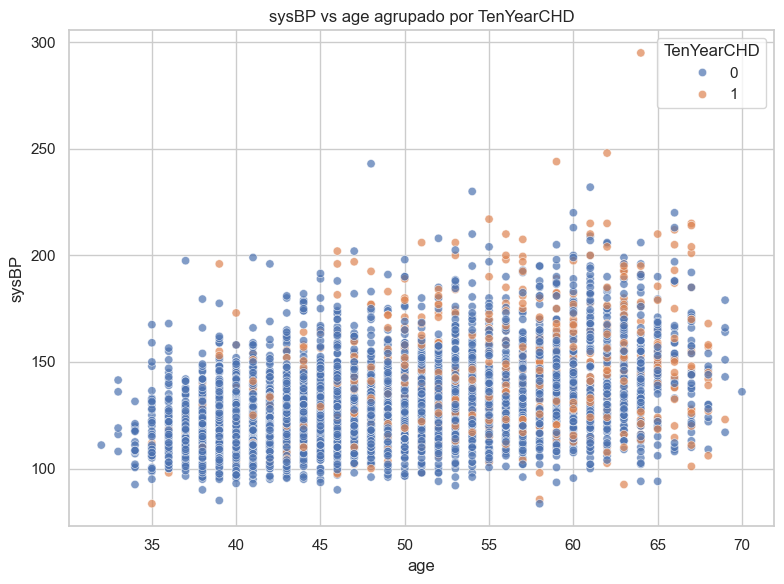

In [32]:
scatter_by_category(
    df_sin_nulls,
    x='age',
    y='sysBP',
    category='TenYearCHD'
)


## IMC vs glucosa (por fumador)

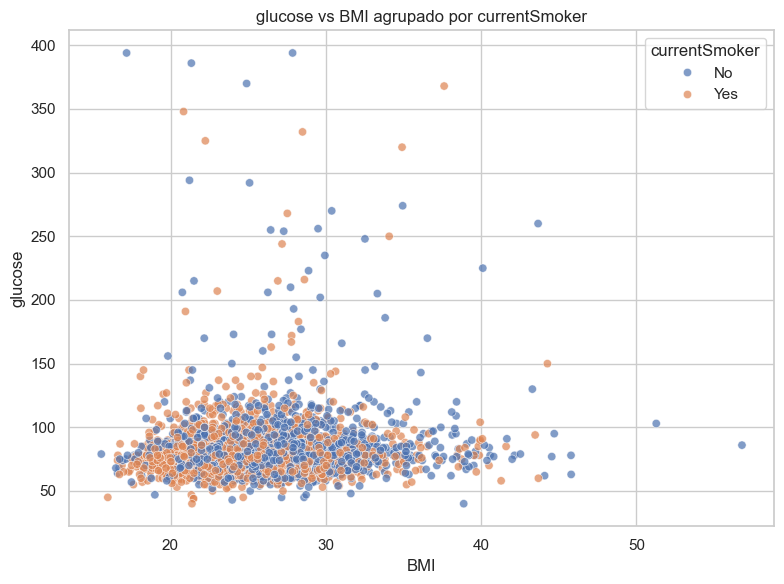

In [33]:
scatter_by_category(
    df_sin_nulls,
    x='BMI',
    y='glucose',
    category='currentSmoker'
)


## Crear ID para identificar a los sujetos

In [34]:
df_sin_nulls = df_sin_nulls.reset_index(drop=True)
df_sin_nulls['subject_id'] = df_sin_nulls.index + 1

In [35]:
df_sin_nulls

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,subject_id
0,M,39,No,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,1
1,F,46,No,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,2
2,M,48,Yes,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,3
3,F,61,Yes,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,4
4,F,46,Yes,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,M,50,Yes,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1,4214
4214,M,51,Yes,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0,4215
4215,F,48,Yes,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0,4216
4216,F,44,Yes,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,78.0,0,4217
